# Проект - Выбор локации для скважины

# Описание проекта

Вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. 

Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. 

Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений; 
- Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Условия задачи:

- Для обучения модели подходит только линейная регрессия (остальные — недостаточно предсказуемые).
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.
- Бюджет на разработку скважин в регионе — 10 млрд рублей.
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.
- После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью.
Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.


# Описание данных:

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).


Инструкция по выполнению проекта
1.	Загрузите и подготовьте данные. Поясните порядок действий.
2.	Обучите и проверьте модель для каждого региона:
- Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
- Обучите модель и сделайте предсказания на валидационной выборке.
- Сохраните предсказания и правильные ответы на валидационной выборке.
- Напечатайте на экране средний запас предсказанного сырья и RMSE модели.
- Проанализируйте результаты.
3.	Подготовьтесь к расчёту прибыли:
- Все ключевые значения для расчётов сохраните в отдельных переменных.
- Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. Сравните полученный объём сырья со средним запасом в каждом регионе. 
- Напишите выводы по этапу подготовки расчёта прибыли.
4.	Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
- Выберите скважины с максимальными значениями предсказаний. 
- Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитайте прибыль для полученного объёма сырья.
5.	Посчитайте риски и прибыль для каждого региона:
- Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
- Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор.


In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('max_columns', None) # показывать все столбцы df
pd.set_option('max_rows', None) # показывать все строки df

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

RS = 12345  # значание random_state
from math import sqrt

In [2]:
# широкоформатный Jupyter
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

## 1.Загрузка и подготовка данных

In [3]:
# загрузка данных
data_0 = pd.read_csv('geo_data_0.csv')
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
# информация по df
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [5]:
# оценка явных дубликатов
data_0.duplicated().sum()

0

In [6]:
# матрица корелляции 
data_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [7]:
# статистиские данные по данным в df
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [8]:
data_1 = pd.read_csv('geo_data_1.csv')
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [9]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
data_1.duplicated().sum()

0

In [11]:
data_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [12]:
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [13]:
data_2 = pd.read_csv('geo_data_2.csv')
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [14]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [15]:
data_2.duplicated().sum()

0

In [16]:
data_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


In [17]:
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


**проверка уникальности объектов по 'id' в данных**

In [18]:
# проверка уникальности объектов по 'id' 
list_number_region = [0,1,2]
list_data = [data_0, data_1, data_2]

for i, j in zip(list_data, list_number_region):
    print('уникальное количество id data_', j, '=', len(i['id'].unique()),', дублирующих строк=',100000-len(i['id'].unique()), sep='')


уникальное количество id data_0=99990, дублирующих строк=10
уникальное количество id data_1=99996, дублирующих строк=4
уникальное количество id data_2=99996, дублирующих строк=4


In [19]:
# выведем строки с одинаковым 'id' на примере data_0
id_data_0_double = pd.Series(data_0['id'].value_counts().head(10).index)
data_0[data_0['id'].isin(id_data_0_double)].sort_values(by='id').head(10)

,id,f0,f1,f2,product
66136,74z30,1.084962,-0.312358,6.990771,127.643327
64022,74z30,0.741456,0.459229,5.153109,140.771492
51970,A5aEY,-0.180335,0.935548,-2.094773,33.020205
3389,A5aEY,-0.039949,0.156872,0.209861,89.249364
69163,AGS9W,-0.933795,0.116194,-3.655896,19.230453
42529,AGS9W,1.454747,-0.479651,0.683380,126.370504
931,HZww2,0.755284,0.368511,1.863211,30.681774
7530,HZww2,1.061194,-0.373969,10.430210,158.828695
63593,QcMuo,0.635635,-0.473422,0.862670,64.578675
1949,QcMuo,0.506563,-0.323775,-2.215583,75.496502


**комментарий** 

- зависимости в строках с одинаковым 'id' не видно, предварительных данных тоже нет, скорее всего это ошибки в данных
- так как количество таких строк небольшое, соотвественно = 10, 4, 4 в данных на 100 000 строк в каждом df, то можно их удалить

In [20]:
id_data_1_double = pd.Series(data_1['id'].value_counts().head(4).index)
id_data_2_double = pd.Series(data_2['id'].value_counts().head(4).index)

# удалим строки с одинаковыми значениями в колонке id
data_0 = data_0[data_0['id'].isin(list(id_data_0_double.values)) == False]
data_1 = data_1[data_1['id'].isin(list(id_data_1_double.values)) == False]
data_2 = data_2[data_2['id'].isin(list(id_data_2_double.values)) == False]

In [21]:
# выведем размеры df и проверим количество уникальных строк по колонке id
for i in [data_0, data_1, data_2]:
    print(i.shape, len(i['id'].unique()))

(99980, 5) 99980
(99992, 5) 99992
(99992, 5) 99992


In [22]:
# удалим из df-ом признаки которые не связаны с целевым признаком - индекс строки
data_0 = data_0.drop(['id'],axis=1)
data_1 = data_1.drop(['id'],axis=1)
data_2 = data_2.drop(['id'],axis=1)

**гистограммы признаков**

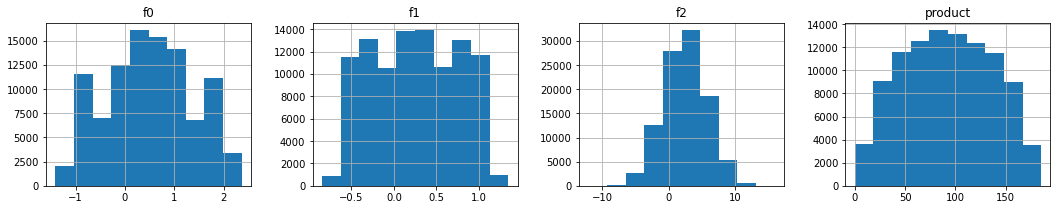

In [23]:
# распределение признаков data_0
data_0.hist(figsize=(18,3), layout=(1,4));

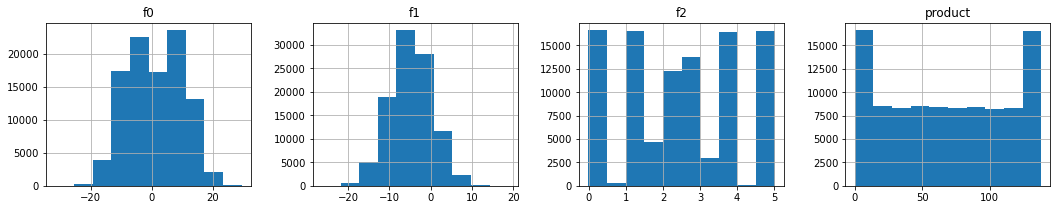

In [24]:
#  распределение признаков data_1
data_1.hist(figsize=(18,3), layout=(1,4));

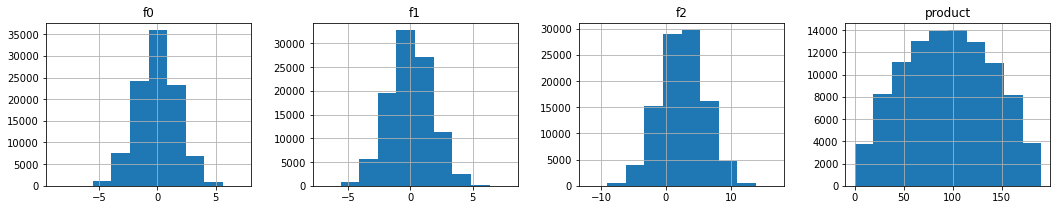

In [25]:
#  распределение признаков data_2
data_2.hist(figsize=(18,3), layout=(1,4));

**комментарий**

распределение признаков, информации по признакам, что они означают, нет
- data_0 - признаки и 'product' распределены нормально, размах значений 'product' 0-185 тыс.барр, медиана - 91 тыс.барр
- data_1 - признак 'f2' и 'product' распределены не равномерно, размах значений 'product' 0-137 тыс.барр, медиана - 57 тыс.барр
- data_2 - признаки и 'product' распределены нормально, размах значений 'product' 0-190 тыс.барр, медиана - 94 тыс.барр

### Итоги, выводы  п.1
- данные трех дата фреймов загруженны
- данные в целом чистые: пропусков, явных дубликатов нет
- обнаружены дубликаты 'id' т.к. это скорее всего ошибки в данных и строк не много 10,4,4 на 1000000 в каждом df - данные строки удалили

- признак 'f2' показывает значимую коррелацию с таргетом 0.48, 0.99, 0.44 по регионам 0,1,2 соответственно 
- признаки 'f0' и 'f1' практически линейно не коррелируют с таргетом

## 2.Обучение и проверка модели

Обучите и проверьте модель для каждого региона:
- Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
- Обучите модель и сделайте предсказания на валидационной выборке.
- Сохраните предсказания и правильные ответы на валидационной выборке.
- Напечатайте на экране средний запас предсказанного сырья и RMSE модели.
- Проанализируйте результаты.

In [26]:
# разделили выборки на признаковые и целевые
features_0 = data_0.drop(['product'], axis=1)
target_0 = data_0['product']
features_1 = data_1.drop(['product'], axis=1)
target_1 = data_1['product']
features_2 = data_2.drop(['product'], axis=1)
target_2 = data_2['product']

In [27]:
# разделили данные на обучающую и валидационную выборки
X_train_0, X_valid_0, y_train_0, y_valid_0 = train_test_split(features_0, target_0, test_size=0.25, random_state=RS)
X_train_1, X_valid_1, y_train_1, y_valid_1 = train_test_split(features_1, target_1, test_size=0.25, random_state=RS)
X_train_2, X_valid_2, y_train_2, y_valid_2 = train_test_split(features_2, target_2, test_size=0.25, random_state=RS)

In [28]:
# данные о размере выборок на примере data_0
print('размеры признаковых выборок', X_train_0.shape, X_valid_0.shape) 
print('размеры выборок по целевому признаку',  y_train_0.shape, y_valid_0.shape) 

размеры признаковых выборок (74985, 3) (24995, 3)
размеры выборок по целевому признаку (74985,) (24995,)


**комментарий**

- данное обучение моделей без масштабирования числовых признаков
- отдельно, в блоке 6 сделал обучение и прогнозирование с масштабированием


In [29]:
# обучение model_0 на data_0  
model_0 = LinearRegression()
model_0.fit(X_train_0, y_train_0) 
model_0_predictions_valid = model_0.predict(X_valid_0) 

In [30]:
# средний запас предсказанного сырья model_0
model_0_predictions_valid.mean()

92.42384109947358

In [31]:
# расчет RMSE
model_0_RMSE = sqrt(mean_squared_error(y_valid_0, model_0_predictions_valid))
print("RMSE модели_0 на валидационной выборке:", model_0_RMSE)

RMSE модели_0 на валидационной выборке: 37.716904960382735


In [32]:
# обучение model_1 на data_1
model_1 = LinearRegression()
model_1.fit(X_train_1, y_train_1) 
model_1_predictions_valid = model_1.predict(X_valid_1) 

In [33]:
# средний запас предсказанного сырья data_1
model_1_predictions_valid.mean()

68.98311857983121

In [34]:
# расчет RMSE
model_1_RMSE = sqrt(mean_squared_error(y_valid_1, model_1_predictions_valid))
print("RMSE модели_1 на валидационной выборке:", model_1_RMSE)

RMSE модели_1 на валидационной выборке: 0.8914901390348559


In [35]:
# обучение model_2 на data_2
model_2 = LinearRegression()
model_2.fit(X_train_2, y_train_2) 
model_2_predictions_valid = model_2.predict(X_valid_2) 

In [36]:
# средний запас предсказанного сырья data_2
model_2_predictions_valid.mean()

95.11622302076479

In [37]:
# расчет RMSE
model_2_RMSE = sqrt(mean_squared_error(y_valid_2, model_2_predictions_valid))
print("RMSE модели_2 на валидационной выборке:", model_2_RMSE)

RMSE модели_2 на валидационной выборке: 39.975543264382345


### Итоги, выводы  п.2
- model_0 - среднее значение предсказанных запасов = 97.59, RMSE = 37.57
- model_1 - среднее значение предсказанных запасов = 68.72, RMSE = 0.89 - модель достаточно точно предсказывает уровень запасов
- model_2 - среднее значение предсказанных запасов = 94.95, RMSE = 40.029



## 3.Подготовка к расчёту прибыли

- Все ключевые значения для расчётов сохраните в отдельных переменных.
- Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины. 
- Сравните полученный объём сырья со средним запасом в каждом регионе.
- Напишите выводы по этапу подготовки расчёта прибыли.

- Бюджет на разработку скважин в регионе — 10 млрд рублей.	
- При нынешних ценах один баррель сырья приносит 450 рублей дохода. 
- Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей
- При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки.


**Зададим переменные используемые в расчетах**

In [38]:
# общий бюджет - total budget
TB = 10000000000 
# количество скважин для расчета прибыли - number_wells_for_calculation 
NVFC = 200 
# количество скважин для Bootstrap - number_well_for_bootstrap
NVFB = 500
# цена за тысячу баррелей - price_thousand_barrels
PTB = 450000
# средняя стоимость разработки 1 скважины - average_cost_development - расчетная величина 
ASD = 0  
# достаточный объём сырья для безубыточной разработки одной новой скважины - sufficient_volume_for_break_even_development 
SVFBED = 0  

**расчеты**

In [39]:
# средняя стоимость разработки одной скважины
ASD =  TB / NVFC
print('Средняя стоимость разработки 1 скважины равна', ASD / 1000000, 'млн.руб.')

Средняя стоимость разработки 1 скважины равна 50.0 млн.руб.


In [40]:
# достаточный объём сырья для безубыточной разработки 1 новой скважины 
# нужно разделить среднею стоимость разработки одной скважины на стоимость в баррелях

SVFBED  = ASD / PTB
print('Достаточный объём сырья для безубыточной разработки одной новой скважины =', round(SVFBED,2), 'тыс.бар')

Достаточный объём сырья для безубыточной разработки одной новой скважины = 111.11 тыс.бар


In [41]:
# Сравните полученный объём сырья со средним запасом в каждом регионе
print('Прогнозный средний запас в регионе 0 =', model_0_predictions_valid.mean())
print('Прогнозный средний запас в регионе 1 =', model_1_predictions_valid.mean())
print('Прогнозный средний запас в регионе 2 =', model_2_predictions_valid.mean())

Прогнозный средний запас в регионе 0 = 92.42384109947358
Прогнозный средний запас в регионе 1 = 68.98311857983121
Прогнозный средний запас в регионе 2 = 95.11622302076479


### Итоги, выводы  п.3
- прогнозные средние запасы на 1 скважину во все регионах ниже, чем средняя стоимость разработки 1 скважины (достаточный объём сырья для безубыточной разработки новой скважины)
- это говорит о том, что мы не можем рандомно выбирать скважины для разработки
- нужно уменьшить количество скважин в расчете, отобрать лучшие и сравнить возможный общий доход с суммой обшего бюджета 

## 4.Расчёт прибыли 

Напишите функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:
- Выберите скважины с максимальными значениями предсказаний. 
- Просуммируйте целевое значение объёма сырья, соответствующее этим предсказаниям.
- Рассчитайте прибыль для полученного объёма сырья.


In [42]:
# сделаем копии изначальных df
data_0_new = data_0.copy()
data_1_new = data_1.copy()
data_2_new = data_2.copy()

# добавляем колонку 'predict' с прогнозыми значениями запасов по модели в новые df
data_0_new['predict'] = model_0.predict(features_0)
data_1_new['predict'] = model_1.predict(features_1)
data_2_new['predict'] = model_2.predict(features_2)

In [43]:
# функция для расчёта прибыли по выбранным скважинам с максимальным запасом по предсказаниям модели, 
# значения запасов из столбца 'product'

def calculation_profits_selected_wells(data, count, total_budget, price_thousand_barrels):
    """
    data - df с признаками, c фактическими данными и прогнозными значениями по скважинам 
    count - число скважин для которых будет сделан расчет по прибыли
    total_budget - общий инвестиционный бюджет
    price_thousand_barrels - цена за 1000 баррелей нефти
    
    функция выподняет действия:
    1) сортируем df по колонке 'predict' по убыванию
    2) отбираем 200 скважин, суммируем столбец 'product, умножаем на стоимость 1000 бар. нефти, вычитаем из общего бюджета
    3) функция возвращает разницу между Суммой добычи на 200 скважинах и Общим бюджетом
    """
    data = data.sort_values(by='predict', ascending=False) 
    return (data['product'][:count].sum() * price_thousand_barrels) - total_budget

In [44]:
# сохраним значений расчета прогнозируемой прибыли прибыли по регионам
total_predict_profit_region_0 = calculation_profits_selected_wells(data_0_new, NVFC, TB, PTB)
total_predict_profit_region_1 = calculation_profits_selected_wells(data_1_new, NVFC, TB, PTB)
total_predict_profit_region_2 = calculation_profits_selected_wells(data_2_new, NVFC, TB, PTB)

In [45]:
list_total_predict = [total_predict_profit_region_0, total_predict_profit_region_1, total_predict_profit_region_2]

for i, val in zip(list_number_region, list_total_predict):
    print(f'Общая прогнозируемая прибыль в регионе {i} по скважинам топ-200 = {val:,.0f} руб.')

Общая прогнозируемая прибыль в регионе 0 по скважинам топ-200 = 3,521,042,648 руб.
Общая прогнозируемая прибыль в регионе 1 по скважинам топ-200 = 2,415,086,697 руб.
Общая прогнозируемая прибыль в регионе 2 по скважинам топ-200 = 2,571,410,632 руб.


### Итоги, выводы  п.4
- создана функция для расчета прибыли 200 скважинами с максимальными значениями предсказания модели и соотвествующих значений 'product'
- наибольший прогноз по прибыли в регионе data_0 = 3,494 млр.руб.

## 5.Посчитайте риски и прибыль для каждого региона

Посчитайте риски и прибыль для каждого региона:
- Примените технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли.
- Найдите среднюю прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль.
- Напишите выводы: предложите регион для разработки скважин и обоснуйте выбор

In [46]:
# подсчет прибыли региона_0 методом Bootstrap с использованием функции calculation_profits_selected_wells
state = np.random.RandomState(RS)
bootstrap_predict_profit_region_0 = []

for i in range(1000):    
    data = data_0_new.sample(n=NVFB, replace=True, random_state=state)
    x = calculation_profits_selected_wells(data, NVFC, TB, PTB)
    bootstrap_predict_profit_region_0.append(x)                                                                             
    

bootstrap_predict_profit_region_0 = pd.Series(bootstrap_predict_profit_region_0)
 
lower = bootstrap_predict_profit_region_0.quantile(q=0.025)
upper = bootstrap_predict_profit_region_0.quantile(q=0.975)

# вывод значений: средняя прибыль, 95%-й доверительный интервал, риск убытков
print(f'Средняя прогнозируемая прибыль методом Bootstrap в регионе_0 = {bootstrap_predict_profit_region_0.mean():,.0f} руб.')
print(f'95%-ый доверительный интервал для региона_0: ({lower:,.0f} руб., {upper:,.0f} руб.)')
print(f'Вероятность убытков для региона_0 = {(bootstrap_predict_profit_region_0 < 0).mean():.1%}')

Средняя прогнозируемая прибыль методом Bootstrap в регионе_0 = 424,227,081 руб.
95%-ый доверительный интервал для региона_0: (-73,590,004 руб., 939,563,112 руб.)
Вероятность убытков для региона_0 = 4.9%


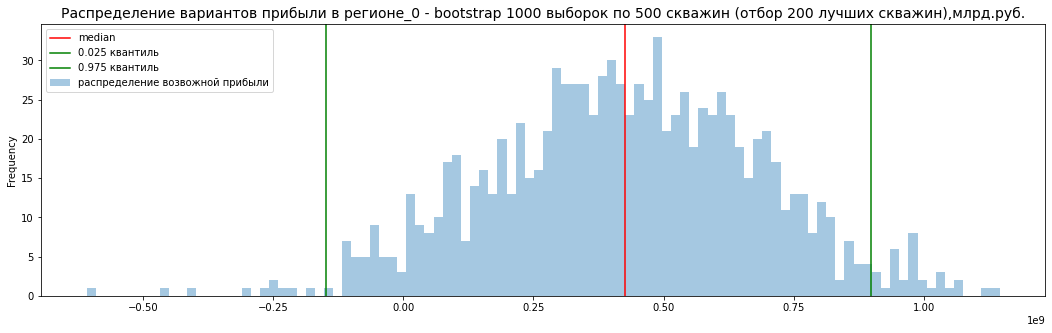

In [74]:
# распределение вариантов прибыли в регионе_0
bootstrap_predict_profit_region_0.plot(kind='hist', bins=100, alpha=0.4, legend=True, figsize=(18,5), 
                                       label='распределение возвожной прибыли')
plt.axvline(x=bootstrap_predict_profit_region_0.median(), color='r', label='median')
plt.axvline(x=lower, color='g', label='0.025 квантиль')
plt.axvline(x=upper, color='g', label='0.975 квантиль')
plt.legend()
plt.title("Распределение вариантов прибыли в регионе_0 - bootstrap 1000 выборок по 500 скважин (отбор 200 лучших скважин), млрд.руб.", 
          fontsize=14);

In [49]:
# подсчет прибыли регион_1 методом Bootstrap с использованием функции calculation_profits_selected_wells
state = np.random.RandomState(RS)
bootstrap_predict_profit_region_1 = []

for i in range(1000):    
    data = data_1_new.sample(n=NVFB, replace=True, random_state=state)
    x = calculation_profits_selected_wells(data, NVFC, TB, PTB)
    bootstrap_predict_profit_region_1.append(x)                                                                             
    

bootstrap_predict_profit_region_1 = pd.Series(bootstrap_predict_profit_region_1)
 
lower = bootstrap_predict_profit_region_1.quantile(q=0.025)
upper = bootstrap_predict_profit_region_1.quantile(q=0.975)

# вывод значений: средняя прибыль, 95%-й доверительный интервал, риск убытков
print(f'Средняя прогнозируемая прибыль методом Bootstrap в регионе_1 = {bootstrap_predict_profit_region_1.mean():,.0f} руб.')
print(f'95%-ый доверительный интервал для региона_1: ({lower:,.0f} руб., {upper:,.0f} руб.)')
print(f'Вероятность убытков для региона_1 = {(bootstrap_predict_profit_region_1 < 0).mean():.1%}')

Средняя прогнозируемая прибыль методом Bootstrap в регионе_1 = 445,362,284 руб.
95%-ый доверительный интервал для региона_1: (7,447,780 руб., 864,416,866 руб.)
Вероятность убытков для региона_1 = 2.4%


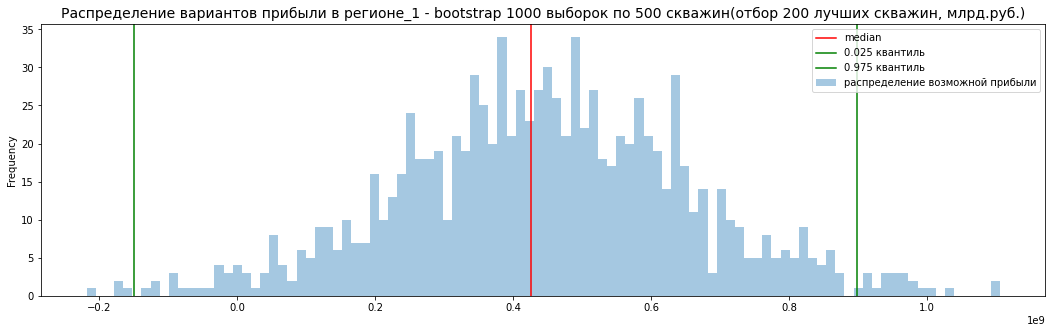

In [75]:
# распределение вариантов прибыли в регионе_1
bootstrap_predict_profit_region_1.plot(kind='hist', bins=100, alpha=0.4, legend=True, figsize=(18,5), 
                                                                   label='распределение возможной прибыли')
plt.axvline(x=bootstrap_predict_profit_region_0.median(), color='r', label='median')
plt.axvline(x=lower, color='g', label='0.025 квантиль')
plt.axvline(x=upper, color='g', label='0.975 квантиль')
plt.legend()
plt.title("Распределение вариантов прибыли в регионе_1 - bootstrap 1000 выборок по 500 скважин(отбор 200 лучших скважин, млрд.руб.)", 
          fontsize=14);

In [51]:
# подсчет прибыли регион_2 методом Bootstrap с использованием функции
state = np.random.RandomState(12345)
bootstrap_predict_profit_region_2 = []

for i in range(1000):    
    data = data_2_new.sample(n=NVFB, replace=True, random_state=state)
    x = calculation_profits_selected_wells(data, NVFC, TB, PTB)
    bootstrap_predict_profit_region_2.append(x)                                                                             
    

bootstrap_predict_profit_region_2 = pd.Series(bootstrap_predict_profit_region_2)
 
lower = bootstrap_predict_profit_region_2.quantile(q=0.025)
upper = bootstrap_predict_profit_region_2.quantile(q=0.975)

# вывод значений: средняя прибыль, 95%-й доверительный интервал, риск убытков
print(f'Средняя прогнозируемая прибыль методом Bootstrap в регионе_2 = {bootstrap_predict_profit_region_2.mean():,.0f} руб.')
print(f'95%-ый доверительный интервал для региона_2: ({lower:,.0f} руб., {upper:,.0f} руб.)')
print(f'Вероятность убытков для региона_1 = {(bootstrap_predict_profit_region_2 < 0).mean():.1%}')

Средняя прогнозируемая прибыль методом Bootstrap в регионе_2 = 370,095,240 руб.
95%-ый доверительный интервал для региона_2: (-148,625,316 руб., 898,062,078 руб.)
Вероятность убытков для региона_1 = 8.1%


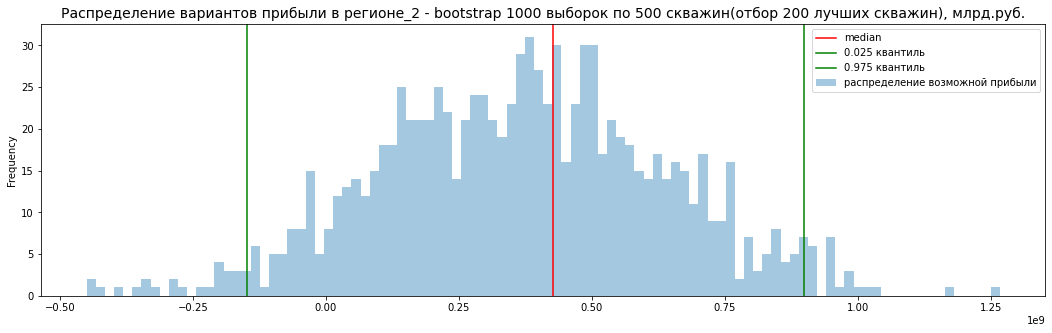

In [76]:
# распределение вариантов прибыли в регионе_2
bootstrap_predict_profit_region_2.plot(kind='hist', bins=100, alpha=0.4, legend=True, figsize=(18,5), 
                                                                   label='распределение возможной прибыли')
plt.axvline(x=bootstrap_predict_profit_region_0.median(), color='r', label='median')
plt.axvline(x=lower, color='g', label='0.025 квантиль')
plt.axvline(x=upper, color='g', label='0.975 квантиль')
plt.legend()
plt.title("Распределение вариантов прибыли в регионе_2 - bootstrap 1000 выборок по 500 скважин(отбор 200 лучших скважин), млрд.руб.", 
          fontsize=14);

### Итоги, выводы  п.5
- расчитанны:  средняя прибыль, 95%-й доверительный интервал, риск убытков методом Bootstrap для всех регионов
- в регионах 0 и 2 вероятность получить убытки больше чем 2.5%, соотвествено 5.2% и 9.2%
- в регионе 1 вероятность получить убытки меньше чем 2.5% -  1.4%

Регион_1
- Средняя прогнозируемая прибыль методом Bootstrap в регионе_1 = 445,362,284 руб.
- 95%-ый доверительный интервал для региона_1: (7,447,780 руб., 864,416,866 руб.)
- Вероятность убытков для региона_1 = 2.4%

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован

## 6.Обучение и предсказание с масштабированием признаков

In [53]:
# масштабируем числовые признаки  для модели_0
numeric = ['f0', 'f1', 'f2']
scaler_0 = StandardScaler()
scaler_0.fit(X_train_0[numeric])  

StandardScaler()

In [54]:
# преобразуем выборки функцией transform()
X_train_0[numeric] = scaler_0.transform(X_train_0[numeric])
X_valid_0[numeric] = scaler_0.transform(X_valid_0[numeric]) 
pd.options.mode.chained_assignment = None

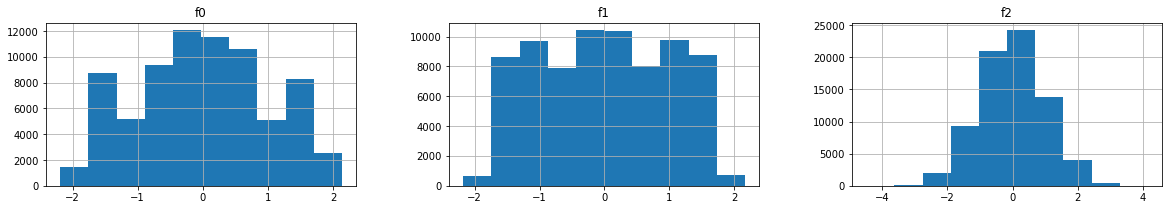

In [55]:
X_train_0.hist(figsize=(20,3), layout=(1,3));

In [56]:
# обучение model_0 на data_0
model_s_0 = LinearRegression()
model_s_0.fit(X_train_0, y_train_0) 
model_s_0_predictions_valid = model_0.predict(X_valid_0) 

In [57]:
model_s_0_predictions_valid.mean()

77.48958138857259

In [58]:
# расчет RMSE
model_s_0_RMSE = sqrt(mean_squared_error(y_valid_0, model_s_0_predictions_valid))
print("RMSE модели_s_0 на валидационной выборке:", model_s_0_RMSE)

RMSE модели_s_0 на валидационной выборке: 43.8054416742357


In [59]:
# масштабируем числовые признаки для модели_1
scaler_1 = StandardScaler()
scaler_1.fit(X_train_1[numeric]) 

StandardScaler()

In [60]:
X_train_1[numeric] = scaler_1.transform(X_train_1[numeric])
X_valid_1[numeric] = scaler_1.transform(X_valid_1[numeric]) 
pd.options.mode.chained_assignment = None

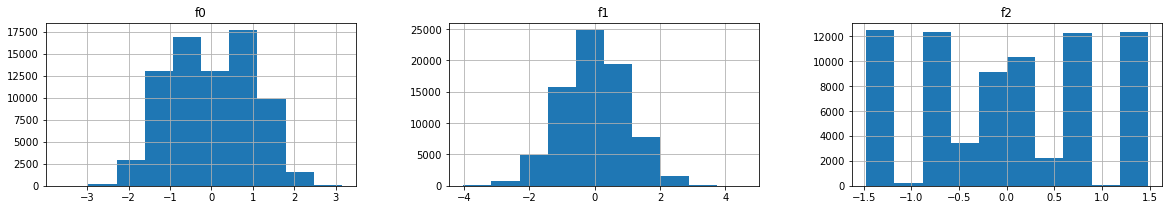

In [61]:
X_train_1.hist(figsize=(20,3), layout=(1,3));

In [62]:
# обучение model_0 на data_0
model_s_1 = LinearRegression()
model_s_1.fit(X_train_1, y_train_1) 
model_s_1_predictions_valid = model_1.predict(X_valid_1) 

In [63]:
model_s_1_predictions_valid.mean()

1.7824371381991775

In [64]:
# расчет RMSE
model_s_1_RMSE = sqrt(mean_squared_error(y_valid_1, model_s_1_predictions_valid))
print("RMSE модели_s_1 на валидационной выборке:", model_s_1_RMSE)

RMSE модели_s_1 на валидационной выборке: 69.84276952411665


In [65]:
# масштабируем числовые признаки для модели_2
scaler_2 = StandardScaler()
scaler_2.fit(X_train_2[numeric]) 

StandardScaler()

In [66]:
# преобразуем выборки функцией transform(). 
X_train_2[numeric] = scaler_2.transform(X_train_2[numeric])
X_valid_2[numeric] = scaler_2.transform(X_valid_2[numeric]) 
pd.options.mode.chained_assignment = None

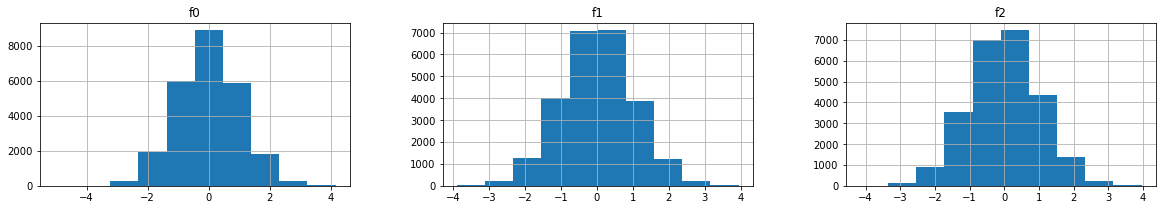

In [67]:
X_valid_2.hist(figsize=(20,3), layout=(1,3));

In [68]:
# обучение model_0 на data_0
model_s_2 = LinearRegression()
model_s_2.fit(X_train_2, y_train_2) 
model_s_2_predictions_valid = model_2.predict(X_valid_2) 

In [69]:
model_s_2_predictions_valid.mean()

80.73247570131696

In [70]:
# расчет RMSE
model_s_2_RMSE = sqrt(mean_squared_error(y_valid_2, model_s_2_predictions_valid))
print("RMSE модели_s_2 на валидационной выборке:", model_s_2_RMSE)

RMSE модели_s_2 на валидационной выборке: 44.52630698611725


**комментарии**  
- model_0_s - уровень предсказанных запасов = 77.48, RMSE = 43.805
- model_1_s - уровень предсказанных запасов = 1.7, RMSE = 69.84 - очень низкикий предсказынный уровень запасов и оценка RMSE
- model_2_s - уровень предсказанных запасов = 80.73, RMSE = 44.52


In [71]:
# сделаем копии изначальных df
data_0_s = data_0.copy()
data_1_s = data_1.copy()
data_2_s = data_2.copy()

# добавляем колонку 'predict' с прогнозыми значениями запасов по модели в новые df
data_0_s['predict'] = model_s_0.predict(features_0)
data_1_s['predict'] = model_s_1.predict(features_1)
data_2_s['predict'] = model_s_2.predict(features_2)

In [72]:
total_predict_profit_region_0_s = calculation_profits_selected_wells(data_0_s, NVFC, TB, PTB)
total_predict_profit_region_1_s = calculation_profits_selected_wells(data_1_s, NVFC, TB, PTB)
total_predict_profit_region_2_s = calculation_profits_selected_wells(data_2_s, NVFC, TB, PTB)

In [73]:
list_total_predict_s = [total_predict_profit_region_0_s, total_predict_profit_region_1_s, total_predict_profit_region_2_s]

for i, val in zip(list_number_region, list_total_predict_s):
    print(f'Общая прогнозируемая прибыль в регионе {i} по скважинам топ-200 = {val:,.0f} руб.')

Общая прогнозируемая прибыль в регионе 0 по скважинам топ-200 = 2,946,837,040 руб.
Общая прогнозируемая прибыль в регионе 1 по скважинам топ-200 = 2,415,086,697 руб.
Общая прогнозируемая прибыль в регионе 2 по скважинам топ-200 = 2,571,410,632 руб.


**Посчет рисков и прибыль для каждого региона методом Bootstrap с 1000 выборок**

In [81]:
# подсчет прибыли региона_0 методом Bootstrap с использованием функции calculation_profits_selected_wells
state = np.random.RandomState(RS)
bootstrap_predict_profit_region_0_s = []

for i in range(1000):    
    data = data_0_s.sample(n=NVFB, replace=True, random_state=state)
    x = calculation_profits_selected_wells(data, NVFC, TB, PTB)
    bootstrap_predict_profit_region_0_s.append(x)                                                                             
    

bootstrap_predict_profit_region_0_s = pd.Series(bootstrap_predict_profit_region_0_s)
 
lower = bootstrap_predict_profit_region_0_s.quantile(q=0.025)
upper = bootstrap_predict_profit_region_0_s.quantile(q=0.975)

# вывод значений: средняя прибыль, 95%-й доверительный интервал, риск убытков
print(f'Средняя прогнозируемая прибыль методом Bootstrap в регионе_0 = {bootstrap_predict_profit_region_0_s.mean():,.0f} руб.')
print(f'95%-ый доверительный интервал для региона_0: ({lower:,.0f} руб., {upper:,.0f} руб.)')
print(f'Вероятность убытков для региона_0 = {(bootstrap_predict_profit_region_0_s < 0).mean():.1%}')

Средняя прогнозируемая прибыль методом Bootstrap в регионе_0 = 331,451,901 руб.
95%-ый доверительный интервал для региона_0: (-171,620,602 руб., 826,593,614 руб.)
Вероятность убытков для региона_0 = 10.3%


In [82]:
# подсчет прибыли региона_1 методом Bootstrap с использованием функции calculation_profits_selected_wells
state = np.random.RandomState(RS)
bootstrap_predict_profit_region_1_s = []

for i in range(1000):    
    data = data_1_s.sample(n=NVFB, replace=True, random_state=state)
    x = calculation_profits_selected_wells(data, NVFC, TB, PTB)
    bootstrap_predict_profit_region_1_s.append(x)                                                                             
    

bootstrap_predict_profit_region_1_s = pd.Series(bootstrap_predict_profit_region_1_s)
 
lower = bootstrap_predict_profit_region_1_s.quantile(q=0.025)
upper = bootstrap_predict_profit_region_1_s.quantile(q=0.975)

# вывод значений: средняя прибыль, 95%-й доверительный интервал, риск убытков
print(f'Средняя прогнозируемая прибыль методом Bootstrap в регионе_1 = {bootstrap_predict_profit_region_1_s.mean():,.0f} руб.')
print(f'95%-ый доверительный интервал для региона_1: ({lower:,.0f} руб., {upper:,.0f} руб.)')
print(f'Вероятность убытков для региона_1 = {(bootstrap_predict_profit_region_1_s < 0).mean():.1%}')

Средняя прогнозируемая прибыль методом Bootstrap в регионе_1 = 445,463,857 руб.
95%-ый доверительный интервал для региона_1: (8,842,611 руб., 864,416,866 руб.)
Вероятность убытков для региона_1 = 2.4%


In [83]:
# подсчет прибыли региона_2 методом Bootstrap с использованием функции calculation_profits_selected_wells
state = np.random.RandomState(RS)
bootstrap_predict_profit_region_2_s = []

for i in range(1000):    
    data = data_2_s.sample(n=NVFB, replace=True, random_state=state)
    x = calculation_profits_selected_wells(data, NVFC, TB, PTB)
    bootstrap_predict_profit_region_2_s.append(x)                                                                             
    

bootstrap_predict_profit_region_2_s = pd.Series(bootstrap_predict_profit_region_2_s)
 
lower = bootstrap_predict_profit_region_2_s.quantile(q=0.025)
upper = bootstrap_predict_profit_region_2_s.quantile(q=0.975)

# вывод значений: средняя прибыль, 95%-й доверительный интервал, риск убытков
print(f'Средняя прогнозируемая прибыль методом Bootstrap в регионе_2 = {bootstrap_predict_profit_region_2_s.mean():,.0f} руб.')
print(f'95%-ый доверительный интервал для региона_2: ({lower:,.0f} руб., {upper:,.0f} руб.)')
print(f'Вероятность убытков для региона_2 = {(bootstrap_predict_profit_region_2_s < 0).mean():.1%}')

Средняя прогнозируемая прибыль методом Bootstrap в регионе_2 = 369,881,028 руб.
95%-ый доверительный интервал для региона_2: (-148,625,316 руб., 902,461,201 руб.)
Вероятность убытков для региона_2 = 8.4%


### Итоги, выводы  п.6

расчитанны: средняя прибыль, 95%-й доверительный интервал, риск убытков методом Bootstrap для всех регионов с масштабированием признаков
- масштабирование признаков для данных df не улучшило прогнозы модели 
- что касается прогноза риска, то масштабирование признаков ухудшидо прогнозы риска
- это свзяанно с тем, что основной коррелирующий признак с таргетом - 'f2', при масштабировании получил больше отрицательных значений, по сравнению с распределением значений 'f2' в исходных df, это видно на графиках расспределений

- в регионах 0 и 2 вероятность получить убытки больше чем 2.5%, соотвествено 10.3% и 8.4%
- в регионе 1 вероятность получить убытки меньше чем 2.5% - 2.4%

Регион_1

- Средняя прогнозируемая прибыль методом Bootstrap в регионе_1 = 445,463,857 руб.
- 95%-ый доверительный интервал для региона_1: (8,842,611 руб., 864,416,866 руб.)
- Вероятность убытков для региона_1 = 2.4%
